In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torch.utils.data import random_split

from torch.optim.lr_scheduler import ReduceLROnPlateau

import tensorboard
from torch.utils.tensorboard import SummaryWriter

from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load Dataset MNIST:

In [4]:
# MNIS Dataset
train_dataset = datasets.MNIST(root='./data',
                               train=True,
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='./data',
                              train=False,
                              transform=transforms.ToTensor(),
                              download=True)

In [5]:
# split train_data to validation and train
train_size = int(0.8 * len(train_dataset))
validation_size = len(train_dataset) - train_size
train_dataset, validation_dataset = random_split(train_dataset, [train_size, validation_size])

In [6]:
# Load Data
def load_data(batch_size=64):
  train_data = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True)

  test_data = DataLoader(dataset=test_dataset,
                        batch_size=batch_size,
                        shuffle=False)

  validation_data = DataLoader(dataset=validation_dataset,
                              batch_size=batch_size,
                              shuffle=False)

  return train_data, test_data, validation_data

In [7]:
# # iterate trought the dataloader
# for images, lables in train_data:
#   print(f'images "{type(images)}" shape: {images.shape}\t,lables "{type(lables)}" shape: {lables.shape}')
#   break


'''
images: [128, 1, 28, 28]:
Batch size: 128 images
Channels: 1 (grayscale)
Height: 28 pixels
Width: 28 pixels
'''

'\nimages: [128, 1, 28, 28]:\nBatch size: 128 images\nChannels: 1 (grayscale)\nHeight: 28 pixels\nWidth: 28 pixels\n'

# MLP Implementation

In [10]:
class MLP(nn.Module):
    def __init__(self, in_features, out_features, hidden_sizes, hidden_activations):
      super(MLP, self).__init__()
      self.model = self.get_model(in_features, out_features, hidden_sizes, hidden_activations)

    def get_activation(self, name):
        activations = {
            'relu': nn.ReLU(),
            'sigmoid': nn.Sigmoid(),
            'tanh': nn.Tanh(),
            'leaky_relu': nn.LeakyReLU()
        }
        return activations[name]

    def get_model(self, in_features, out_features, hidden_sizes, hidden_activations):
        layers = [nn.Flatten()]

        input_dim = in_features
        for i in range(len(hidden_sizes)):
            layers.append(nn.Linear(input_dim, hidden_sizes[i]))
            layers.append(self.get_activation(hidden_activations[i]))
            input_dim = hidden_sizes[i]

        layers.append(nn.Linear(input_dim, out_features))

        model = nn.Sequential(*layers)
        return model

    def get_optimizer(self, name, lr, momentum=0.9):
        optimizers = {
            'SGD': torch.optim.SGD(params=self.model.parameters(), lr=lr, momentum=momentum),
            'Adam': torch.optim.Adam(params=self.model.parameters(), lr=lr),
            'RMSprop': torch.optim.RMSprop(params=self.model.parameters(), lr=lr)
        }
        return optimizers[name]

    def get_criterion(self, name):
        criteria = {
            'CrossEntropyLoss': nn.CrossEntropyLoss()
        }
        return criteria[name]

    def train_model(self, train_data, validation_data, optimizer_name,
                    lr, num_epochs, convergence_threshold=1e-6, lambda_reg=0.0001):

        print("Training Started")

        model = self.model.to(device)
        criterion = self.get_criterion("CrossEntropyLoss")
        optimizer = self.get_optimizer(optimizer_name, lr)
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

        num_batches = len(train_data)
        train_losses = []
        val_losses = []

        best_val_loss = float('inf')
        patience = 5
        wait = 0

        for epoch in range(num_epochs):
            model.train()
            running_loss = 0.0

            for i, (images, labels) in enumerate(train_data):
                images, labels = images.to(device), labels.to(device)

                # Forward pass
                outputs = model(images)

                # Compute loss
                loss = criterion(outputs, labels)
                l2_reg_loss = sum(torch.norm(param) ** 2 for param in model.parameters())
                loss += lambda_reg * l2_reg_loss

                # Backward pass and optimization
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

            # Validation loop
            val_loss = 0.0
            model.eval()
            with torch.no_grad():
                for images, labels in validation_data:
                    images, labels = images.to(device), labels.to(device)

                    # Forward pass
                    outputs = model(images)

                    # Compute loss
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()


            # Early stopping and convergence check
            if (val_loss / len(validation_data)) < best_val_loss:
                best_val_loss = val_loss / len(validation_data)
                wait = 0
            else:
                if ((val_loss / len(validation_data)) - best_val_loss) > 1e-3:
                    wait += 1
                if wait >= patience:
                    print(f'Early stopped in epoch {epoch + 1}/{num_epochs}')
                    break

            if epoch > 5:
                pre_loss = train_losses[-1]
                if abs(pre_loss - running_loss) < convergence_threshold:
                    print(f'Convergence in epoch {epoch + 1}/{num_epochs}')
                    break


            current_lr = optimizer.param_groups[0]['lr']
            print(f'Epoch {epoch + 1}/{num_epochs}: Training Loss: {running_loss / len(train_data):.4f}, Validation Loss: {val_loss / len(validation_data):.4f}, lr: {current_lr}')
            train_losses.append(running_loss / len(train_data))
            val_losses.append(val_loss / len(validation_data))

            # Update the learning rate
            scheduler.step(running_loss / len(train_data))

        print("Training finished")
        return train_losses, val_losses

    def test_model(self, test_data):
        model = self.model.to(device)
        model.eval()

        true_labels = []
        predicted_labels = []
        total = 0
        correct = 0

        with torch.no_grad():
            for images, labels in test_data:
                images, labels = images.to(device), labels.to(device)

                # Forward pass
                outputs = model(images)

                # Get the predicted class
                _, predicted = torch.max(outputs, dim=1)

                total += labels.shape[0]
                correct += (predicted == labels).sum().item()

                true_labels.extend(labels.cpu().numpy())
                predicted_labels.extend(predicted.cpu().numpy())

        acc = 100 * correct / total
        return acc, true_labels, predicted_labels


In [11]:
# Hyperparameters

batch_size = 64
in_features = 28 * 28
out_features = 10
hidden_sizes = [128, 64, 32]
hidden_activations = ["relu", "sigmoid", "sigmoid"]


optimizer_name = "Adam"
learning_rate = 1e-3
num_epochs = 10
convergence_threshold = 1e-6
lambda_reg = 1e-4

train_data, test_data, validation_data = load_data(batch_size)

model1 = MLP(in_features, out_features, hidden_sizes, hidden_activations)

train_losses, val_losses = model1.train_model(train_data=train_data,
                                              validation_data=validation_data,
                                              optimizer_name=optimizer_name,
                                              lr=learning_rate,
                                              num_epochs=num_epochs,
                                              convergence_threshold=convergence_threshold,
                                              lambda_reg=lambda_reg)

acc, true_labels, predicted_labels = model1.test_model(test_data=test_data)
print(f'Accuracy of the model on the test images: {acc}%')

Training Started
Epoch 1/10: Training Loss: 1.0051, Validation Loss: 0.3295, lr: 0.001
Epoch 2/10: Training Loss: 0.3012, Validation Loss: 0.1919, lr: 0.001
Epoch 3/10: Training Loss: 0.2190, Validation Loss: 0.1383, lr: 0.001
Epoch 4/10: Training Loss: 0.1845, Validation Loss: 0.1245, lr: 0.001
Epoch 5/10: Training Loss: 0.1650, Validation Loss: 0.1097, lr: 0.001
Epoch 6/10: Training Loss: 0.1531, Validation Loss: 0.1012, lr: 0.001
Epoch 7/10: Training Loss: 0.1434, Validation Loss: 0.0960, lr: 0.001
Epoch 8/10: Training Loss: 0.1374, Validation Loss: 0.0965, lr: 0.001
Epoch 9/10: Training Loss: 0.1319, Validation Loss: 0.0908, lr: 0.001
Epoch 10/10: Training Loss: 0.1273, Validation Loss: 0.0976, lr: 0.001
Training finished
Accuracy of the model on the test images: 97.24%


In [12]:
def plot_train_val_loss(train_losses, val_losses):
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.yscale('log')
    plt.legend()

def plot_confusion_matrix(true_labels, predicted_labels):
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')


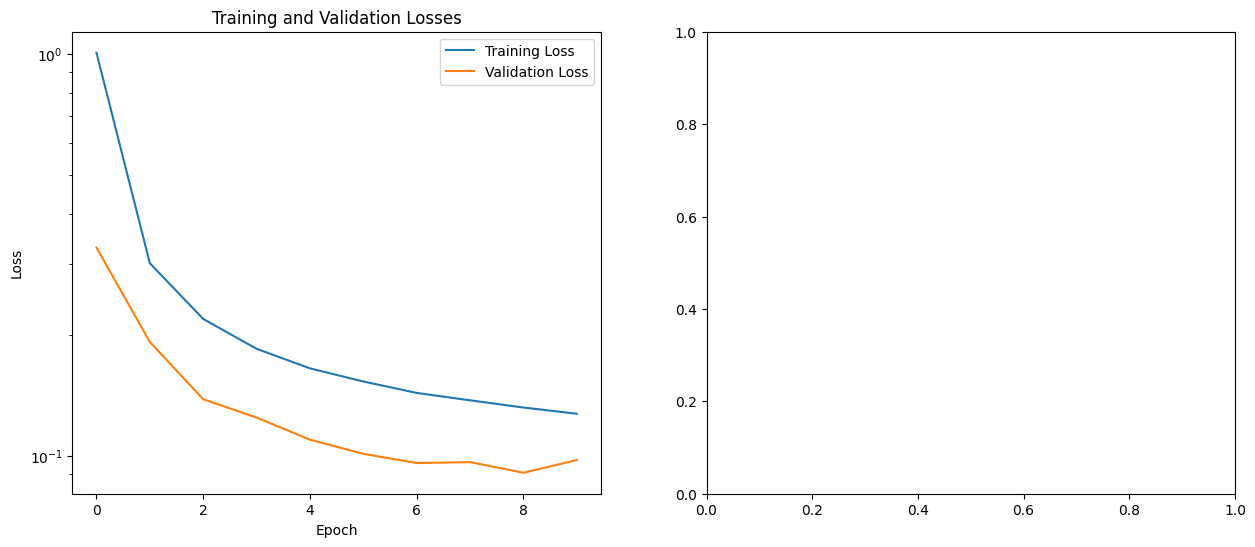

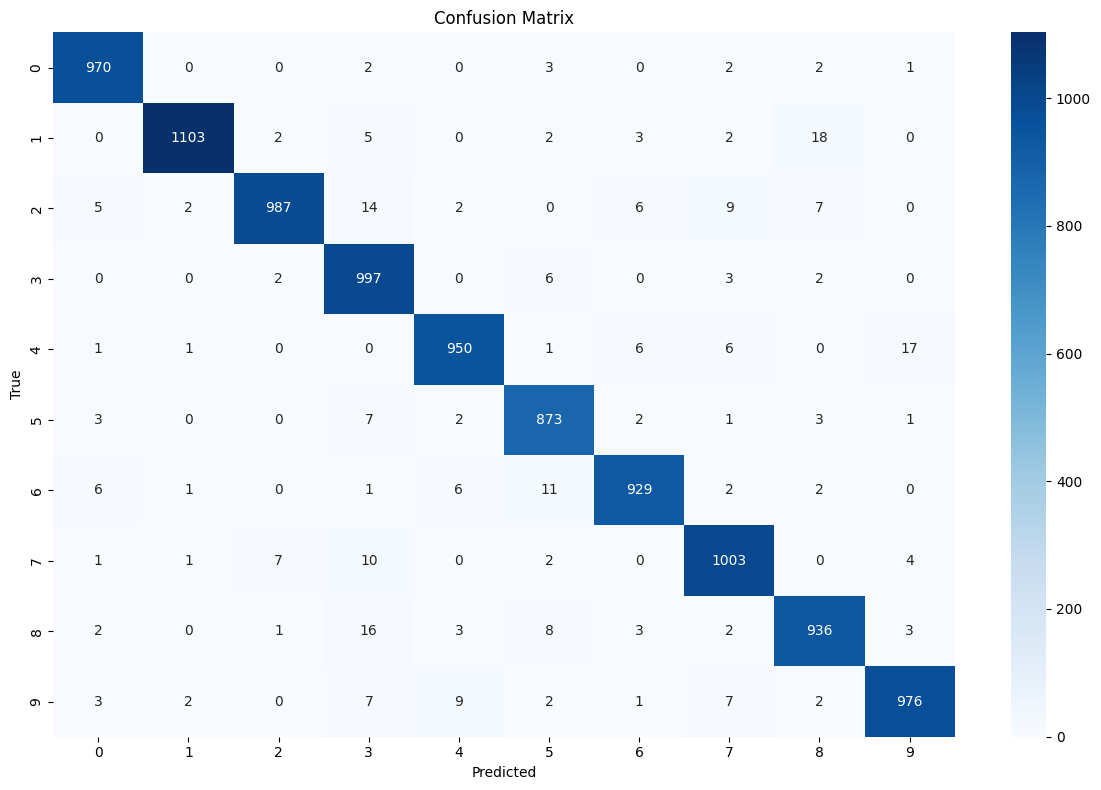

In [13]:
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plot_train_val_loss(train_losses, val_losses)

plt.subplot(1, 2, 2)
plot_confusion_matrix(true_labels, predicted_labels)

plt.tight_layout()
plt.show()